# Solutions for block E

In [1]:
import pandas
import geopandas
import contextily
from pysal.lib import examples
from pysal.lib import weights
import matplotlib.pyplot as plt

## Task I

- Grab data paths

In [2]:
nyc_data = examples.load_example("NYC Socio-Demographics")

- Read data

In [3]:
nyc = geopandas.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

- Queen contiguity matrix

In [4]:
w_queen = weights.Queen.from_dataframe(nyc)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 0, 626, 2165.
  warnings.warn(message)


- Neighbors of Central Park (id `142`)

In [5]:
w_queen[142]

{192: 1.0,
 130: 1.0,
 195: 1.0,
 199: 1.0,
 137: 1.0,
 204: 1.0,
 141: 1.0,
 145: 1.0,
 151: 1.0,
 152: 1.0,
 153: 1.0,
 156: 1.0,
 222: 1.0,
 161: 1.0,
 165: 1.0,
 166: 1.0,
 167: 1.0,
 171: 1.0,
 187: 1.0,
 110: 1.0,
 111: 1.0,
 174: 1.0,
 175: 1.0,
 114: 1.0,
 179: 1.0,
 180: 1.0,
 181: 1.0,
 183: 1.0,
 123: 1.0,
 191: 1.0}

We can get the computer to count the number of neighbors:

In [6]:
len(w_queen[142])

30

An alternative way is through the `cardinality` property of weights:

In [7]:
w_queen.cardinalities[142]

30

- Zoom plot

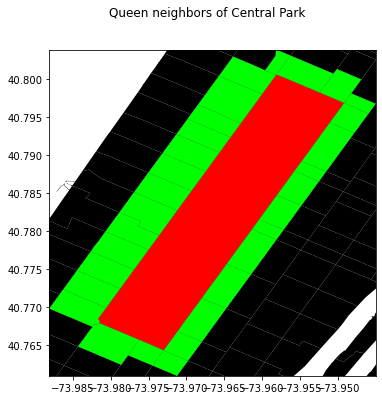

In [8]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
nyc.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = nyc.loc[[142], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = nyc.loc[w_queen[142], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of Central Park")
# Style and display on screen
e, s, w, n = neis.total_bounds # Retrieve smallest rectangle containing all of neighbors
ax.set_xlim(e, w)
ax.set_ylim(s, n)
plt.show()

- `borocode` block weights

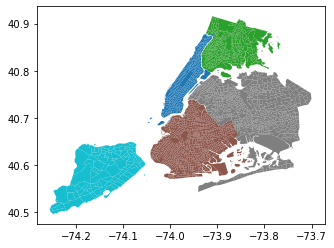

In [9]:
nyc.plot(column='borocode', categorical=True);

In [10]:
w_block = weights.block_weights(nyc["borocode"])

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


Comparison of cardinalities (number of neighbors by tract):

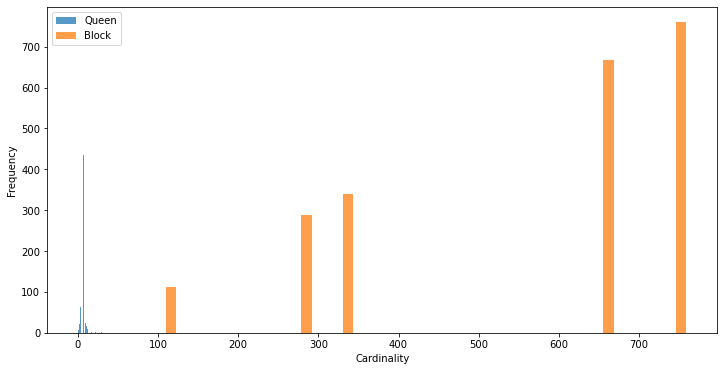

In [11]:
ax = pandas.Series(w_queen.cardinalities).plot.hist(bins=50, 
                                                    alpha=0.75, 
                                                    label="Queen",
                                                    figsize=(12, 6)
                                                   )
pandas.Series(w_block.cardinalities).plot.hist(bins=50, 
                                               alpha=0.75, 
                                               ax=ax, 
                                               label="Block"
                                              )
ax.set_xlabel("Cardinality")
ax.legend();

The block weights show a much higher cardinality because everyone in a borough gets to be the neighbor of everyone else in that borogouh, and there are only five boroughs. The queen criterium is limited to geographic contiguity for every polygon, hence the number of neighbors is much more limited.

## Task II

- Set data up

In [12]:
jp_cities = geopandas.read_file("http://www.oecd.org/cfe/regionaldevelopment/Japan.zip")
jp = jp_cities.to_crs(epsg=2459)
jp.geometry = jp.geometry.centroid

- Map

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 14, 17, 30, 54.
  warnings.warn(message)


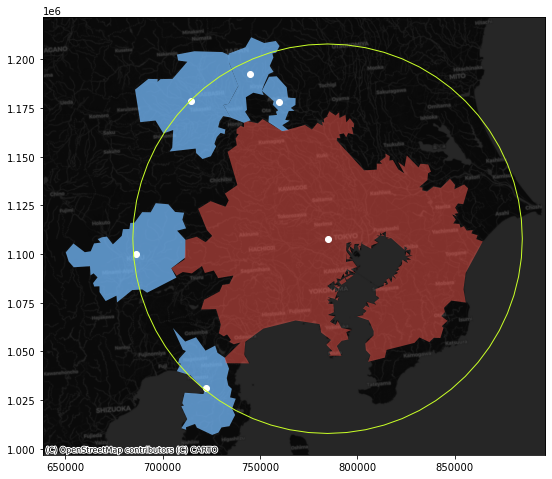

In [13]:
w = weights.DistanceBand.from_dataframe(jp, 100000)
tokyo = jp.query("fuaname == 'Tokyo'").index[0]
buff = jp.loc[[tokyo], :].buffer(100000)
neis_df = jp_cities.loc[w.neighbors[tokyo]].to_crs(jp.crs)

# Plot neighbors
ax = neis_df.plot(color="xkcd:sky blue", alpha=0.75, figsize=(9, 9))
# Plot Tokyo in red
jp_cities.to_crs(jp.crs).loc[[tokyo], :].plot(ax=ax, color="xkcd:coral", alpha=0.5)
# Plot Tokyo centroid in white
jp_cities.to_crs(jp.crs).loc[[tokyo], :].centroid.plot(ax=ax, color="white")
# Plot neighbor centroids in white
neis_df.centroid.plot(ax=ax, color="white")
# Plot buffer in green
buff.plot(ax=ax, facecolor="none", edgecolor="xkcd:green yellow")
# Add basemap
contextily.add_basemap(ax, 
                       crs=jp.crs, 
                       source=contextily.providers.CartoDB.DarkMatter
                      )

### Task III

In [14]:
lsoas = geopandas.read_file("Access_to_Healthy_Assets_and_Hazards_AHAH_E08000012/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")
ahah_data = pandas.read_csv("Access_to_Healthy_Assets_and_Hazards_AHAH_E08000012/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv")
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")
ahah.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 51 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lsoa11cd      298 non-null    object  
 1   geometry      298 non-null    geometry
 2   lsoa11nm      298 non-null    object  
 3   r_rank        298 non-null    int64   
 4   h_rank        298 non-null    int64   
 5   g_rank        298 non-null    int64   
 6   e_rank        298 non-null    int64   
 7   r_exp         298 non-null    float64 
 8   h_exp         298 non-null    float64 
 9   g_exp         298 non-null    float64 
 10  e_exp         298 non-null    float64 
 11  ahah          298 non-null    float64 
 12  r_ahah        298 non-null    int64   
 13  d_ahah        298 non-null    int64   
 14  r_dec         298 non-null    int64   
 15  h_dec         298 non-null    int64   
 16  g_dec         298 non-null    int64   
 17  e_dec         298 non-null    int64   
 18  gp

- Spatial Lag of AHAH

In [15]:
w = weights.Queen.from_dataframe(ahah)
w.transform = "R"
ahah["w_ahah"] = weights.lag_spatial(w, ahah["ahah"])

- Moran Plot

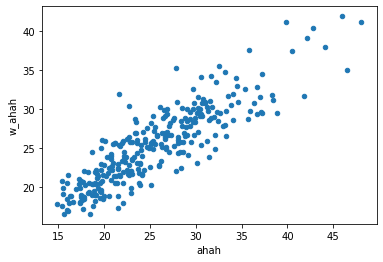

In [16]:
ahah[["ahah", "w_ahah"]].plot.scatter("ahah", "w_ahah");

There seems to be a pattern of positive spatial autocorrelation, by which high values of the AHAH score in a given LSOA are associated *also* with high values of the AHAH score in the neighbors, measured by the queen contiguity.